In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.spatial
import pandas as pd
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from utils.readProfiles import readMergedProfiles
from utils.pred_models import *
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile
from multiprocessing import Pool

sns.set_style("whitegrid")
# from utils import networksEvol, tsne, readProfiles
import umap

### In this notebook you can find your answer to these questions:

1. What genes are related to your CP feature?
2. What CP features are related to your Gene under study?


* Due to quality of overall predictions as reported in the paper, we use:
   - **LINCS** dataset for chemical perturbation reference 
   - **LUAD** dataset for genetic perturbation reference 


## User input parameters

In [2]:
# In which perturbation context you want to explore your features
# "genetic" or "chemical"
which_dataset_to_use="genetic"

cp_features_under_test=['Cytoplasm_AreaShape_Zernike_9_3','Cells_RadialDistribution_RadialCV_Mito_1of4']
ge_features_under_test=['',]

#### Paths

In [3]:
procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
metadata_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/'
results_dir='./results/'


## What genes are related to your CP feature?

In [9]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
datasets=['TAORF'];
# datasets=['LINCS', 'CDRP-bio','CDRP'];

DT_kfold={'LUAD':10, 'TAORF':5, 'LINCS':25, 'CDRP-bio':6,'CDRP':40}

################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
# highRepOverlapEnabled=0
# 'highRepUnion','highRepOverlap'
filter_perts='highRepOverlap'

################################################
pertColName='PERT'
profileLevel='treatment'; #'replicate'  or  'treatment'
if highRepOverlapEnabled:
    f='filt'
else:
    f=''
    
# def f(dataset):
for dataset in datasets:
   
    
    nRep=2
    mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features=\
    readMergedProfiles(procProf_dir,dataset,profileType,profileLevel,nRep,highRepOverlapEnabled);


#     if profileLevel=='replicate':
#         l1k=mergProf_repLevel[[pertColName]+l1k_features]
#         cp=mergProf_repLevel[[pertColName]+cp_features]
#     elif profileLevel=='treatment':
    l1k=mergProf_treatLevel[[pertColName]+l1k_features]
    cp=mergProf_treatLevel[[pertColName]+cp_features]


    if dataset=='LINCS':     
        cp['Compounds']=cp['PERT'].str[0:13]
        l1k['Compounds']=l1k['PERT'].str[0:13]
    else:
        cp['Compounds']=cp['PERT']
        l1k['Compounds']=l1k['PERT']      


    le = preprocessing.LabelEncoder()
    group_labels=le.fit_transform(l1k['Compounds'].values)


    scaler_ge = preprocessing.StandardScaler()
    scaler_cp = preprocessing.StandardScaler()
    l1k_scaled=l1k.copy()
    l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
    cp_scaled=cp.copy()
    cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))
    
    
    for model in ["MLP"]:#["Lasso","MLP","RFR"]:    

        if 1:
            cp=cp_scaled.copy()
            l1k=l1k_scaled.copy()

        ##############################
         
        k_fold=DT_kfold[dataset]
#         k_fold=int(np.unique(group_labels).shape[0]/4)
#         if dataset=='TAORF' or dataset=='CDRP':     
#             k_fold=DT_kfold[dataset]
# #             k_fold=int(np.unique(group_labels).shape[0]/20)              
#         else:
#             k_fold=int(np.unique(group_labels).shape[0]/20)  
            
        pred_df=pd.DataFrame(index=range(k_fold),columns=l1k_features)
        pred_df_rand=pd.DataFrame(index=range(k_fold),columns=l1k_features)
        ii=0
        for l in l1k_features:
            ii+=1
            print(ii)
            if model=="Lasso":
                scores,scores_rand=lasso_cv_plus_model_selection(cp[cp_features],l1k[l],k_fold,group_labels)        
#                 scores,scores_rand=lasso_cv(cp[cp_features],l1k[l],k_fold,group_labels)
            elif model=="MLP":
                scores,scores_rand=MLP_cv_plus_model_selection(cp[cp_features],l1k[l],k_fold,group_labels)
#                 scores,scores_rand=MLP_cv(cp[cp_features],l1k[l],k_fold,group_labels)  
            elif model=="RFR":
                scores,scores_rand=RFR_cv_plus_model_selection(cp[cp_features],l1k[l],k_fold,group_labels)  
            
            pred_df[l]=scores
            pred_df_rand[l]=scores_rand

#         gafgfdssgfd
        ########################### mapping prob_ids to genes names    
        meta=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/affy_probe_gene_mapping.txt",delimiter="\t",header=None, names=["probe_id", "gene"])
        meta_gene_probID=meta.set_index('probe_id')
        d = dict(zip(meta_gene_probID.index, meta_gene_probID['gene']))
        pred_df = pred_df.rename(columns=d)    
        pred_df_rand = pred_df_rand.rename(columns=d)  


        meltedPredDF=pd.melt(pred_df).rename(columns={'variable':'lmGens','value':'pred score'})
        meltedPredDF_rand=pd.melt(pred_df_rand).rename(columns={'variable':'lmGens','value':'pred score'})
        meltedPredDF['d']="n-folds"
        meltedPredDF_rand['d']="random"
        filename=results_dir+'/SingleGenePred/scores.xlsx'
        
        profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])
        
        saveAsNewSheetToExistingFile(filename,pd.concat([meltedPredDF,meltedPredDF_rand],ignore_index=True),\
                                     model+'-'+dataset+'-'+profTypeAbbrev+'-'+f+'-'+str(k_fold)+'-ht')
        
#     return 

# with Pool(10) as p:
#     p.map(f, datasets)

TAORF: Replicate Level Shapes (nSamples x nFeatures): cp:  1920 , 63 ,  l1k:  729 , 978
l1k n of rep:  2.0
cp n of rep:  5.0
Treatment Level Shapes (nSamples x nFeatures+metadata): (324, 65) (328, 980) Merged Profiles Shape: (150, 1044)


<ipython-input-9-c4706d5a765f>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['Compounds']=cp['PERT']
<ipython-input-9-c4706d5a765f>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1k['Compounds']=l1k['PERT']


1


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


2
3
4
5
6
7
8
9
10
11
12


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


13
14


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


15


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


16
17
18
19
20
21
22
23


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


24
25
26


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


27


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


28


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


29
30
31


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


32
33
34
35
36
37
38
39
40
41


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


42
43
44
45
46
47
48
49
50
51


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


52
53
54
55
56
57
58


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


59
60
61
62
63


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


64
65
66
67
68
69
70
71
72
73
74
75
76


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


77
78
79
80
81


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


82
83
84
85
86
87


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


88
89


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


90
91
92
93


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


94


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


95
96
97
98
99
100


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


101


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


102
103
104
105
106
107
108


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/sit

109


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


110
111
112
113
114
115


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


116
117
118
119
120
121
122
123
124


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


125
126
127
128
129
130


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


131


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


132
133


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


134
135
136


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


137
138
139
140
141


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


142
143
144


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


145
146
147


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


171
172
173
174


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


175
176
177
178


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


179
180
181
182
183


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


184
185
186
187


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


188
189
190
191
192


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


193
194
195
196


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


197
198
199
200
201
202
203
204
205
206
207
208
209
210


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/sit

211
212


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


213
214
215
216
217
218
219
220


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


221
222


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


223
224


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


225
226
227
228
229


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


230
231
232
233
234
235
236
237
238
239
240


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


241
242
243
244
245
246
247


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


267


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


268
269


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


270
271
272
273
274
275


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


276
277
278
279
280


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


281
282
283


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


284
285


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


286
287


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


288
289


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


290


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


291
292


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


293
294


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


295
296
297
298
299


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


300
301
302


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


303
304
305
306
307
308
309


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


310
311


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


312
313
314
315


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


316


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


317
318


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


319
320
321
322
323
324
325
326
327
328
329
330
331
332


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


333


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


334


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


335
336
337
338
339
340
341
342


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


343
344
345
346
347
348
349


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


350
351
352
353
354


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


355
356
357
358
359
360


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


361
362
363


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


364
365


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


366
367
368
369


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


370
371
372


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


373
374
375
376
377
378
379
380
381
382
383


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


384
385
386
387
388
389
390
391


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


392
393
394
395
396
397


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


398
399
400
401


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


402
403
404
405


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


406


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


407
408


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


409
410
411
412
413
414
415
416
417
418
419
420


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


421


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


422
423
424


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


425


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


426
427
428
429
430
431
432
433
434
435
436
437
438


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


439


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


440
441
442
443
444
445
446
447
448
449
450
451
452
453
454


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


455
456
457


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


458
459
460
461
462
463
464
465
466


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


467
468
469
470
471
472
473
474
475
476


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


496
497
498


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


499
500


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


501
502


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


503


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


504
505
506
507
508
509
510
511
512


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


513
514
515
516
517
518
519


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


520
521
522
523


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


524
525


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


542
543


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


544
545
546


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


547
548
549
550


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


551
552
553
554
555


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


556
557
558


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


559
560
561


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


562
563


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/sit

564
565


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/sit

566
567
568
569
570
571
572
573
574
575
576


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


577


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


578
579
580
581
582
583


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


584
585
586


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


587
588
589
590
591
592
593


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


594
595
596
597


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


614
615
616
617
618
619


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


620


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


621
622
623
624
625
626
627
628
629
630
631


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


632
633
634
635
636
637


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


638


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


639


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


640


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


641


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


642


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


643
644
645
646
647


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


648
649
650
651
652
653
654


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


655
656
657
658


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/sit

659
660
661
662
663
664
665
666
667
668
669


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/sit

670
671


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


672
673
674
675
676
677
678
679


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


680
681


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


682
683
684
685


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


686
687
688
689


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


690


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


691


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


692
693
694
695
696
697
698
699
700
701
702
703


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


704
705
706


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


707
708


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


709


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


710
711
712


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


713


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


714


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


715
716


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


717
718
719
720
721
722
723
724


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


725
726
727
728
729


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


730
731
732
733
734
735
736
737
738
739


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


740
741
742


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


743
744
745


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


746
747
748
749
750


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/sit

751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


776
777
778
779
780
781
782
783
784
785
786
787


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


788
789


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


790
791
792
793
794
795
796


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


797
798
799
800
801
802
803


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


804
805
806


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


807
818
819
820
821
822
823
824
825


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


826
827
828


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


829


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


830
831
832
833
834
835


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


836
837


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


838
839
840
841
842
843
844
845
846
847
848
849


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


850
851
852
853
854
855
856
857


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


858


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


859


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


860


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


861
862


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


863


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


864


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


865


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


866


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


883


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


884
885


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


886


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


887


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


888
889
890
891
892
893
894
895


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


896


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


897


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


898
899
900
901
902
903


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


904


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


905
906
907
908
909
910
911
912
913
914


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


915


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


916
917
918
919
920
921
922
923
924
925
926


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


927
928


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


929
930
931
932


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


933
934
935
936
937
938
939
940
941
942
943


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


944
945
946
947


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


948


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


949
950


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


951
952


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


953
954


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


955
956
957
958


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


959
960
961


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


962


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


963


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


964
965
966


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


967


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


968
969
970


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


971


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


972


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


973
974


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


975
976
977
978
MLP-TAORF-nvs--5-ht  saved!


In [13]:
# scores,scores_rand=lasso_cv_plus_model_selection(cp[cp_features],l1k[l],k_fold,group_labels)
alphas = np.linspace(0, 0.2, 20)
np.concatenate((alphas,np.linspace(0.2, 0.5, 10)[1:]))
# np.logspace(-4, -0.5, 30)

array([0.        , 0.01052632, 0.02105263, 0.03157895, 0.04210526,
       0.05263158, 0.06315789, 0.07368421, 0.08421053, 0.09473684,
       0.10526316, 0.11578947, 0.12631579, 0.13684211, 0.14736842,
       0.15789474, 0.16842105, 0.17894737, 0.18947368, 0.2       ,
       0.23333333, 0.26666667, 0.3       , 0.33333333, 0.36666667,
       0.4       , 0.43333333, 0.46666667, 0.5       ])

In [10]:
# np.linspace(0, 1, 10)
# scores_rand
pred_df.mean().sort_values()

202870_s_at   -16.070872
209899_s_at   -10.784372
203315_at      -7.462818
204126_s_at    -6.800885
201323_at      -6.340889
                 ...    
201870_at       0.398052
209875_s_at     0.413801
210986_s_at     0.474941
210719_s_at     0.509600
201032_at       0.511457
Length: 978, dtype: float64

In [21]:
np.array(scores)

array([0.57400963, 0.58238021, 0.58851821, 0.54148807, 0.6773486 ,
       0.5438055 , 0.64596831, 0.2438296 , 0.52226319])

In [24]:
np.array(scores)

array([0.61805801, 0.61410161, 0.71590492, 0.5401769 , 0.7256939 ,
       0.6572162 , 0.62939806, 0.35729642, 0.54652747])

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


-0.0008916206554699711


(-0.5, 0.5)

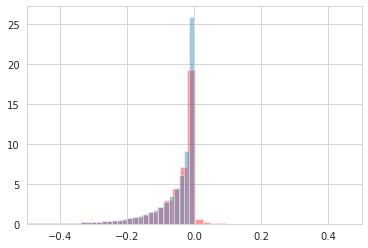

In [18]:
# pred_scoress=d_to_pl[d_to_pl["d"]=="n-folds"]["pred score"].values
#         pred_scoress=res_sheet[res_sheet['d']=='n-folds']["pred score"].values
# rand_scoress=d_to_pl[d_to_pl["d"]=="random"]["pred score"].values
#         rand_scoress=res_sheet[res_sheet['d']=='random']["pred score"].values
sns.distplot(meltedPredDF['pred score'].values,kde=False,hist=True,bins=200,norm_hist=True,color='r')
sns.distplot(meltedPredDF_rand['pred score'].values,kde=False,hist=True,bins=200,label='random',norm_hist=True)
print(np.percentile(meltedPredDF_rand['pred score'].values,90))
# plt.xlim(-1,1)
plt.xlim(-.5,.5)

In [ ]:
# meltedPredDF.groupby()

## Prediction of single CP features based on the full GE profiles

## What are the Genes invloved in predicting a CP feature

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1023,1028) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


LUAD: Replicate Level Shapes (nSamples x nFeatures): cp:  6144 , 1569 ,  l1k:  4232 , 978
l1k n of rep:  8.0
cp n of rep:  8.0
CP: from  593  to  364
l1k: from  529  to  275
CP and l1k high rep overlap:  197
Treatment Level Shapes (nSamples x nFeatures+metadata): (198, 1572) (198, 979) Merged Profiles Shape: (198, 2550)


<ipython-input-56-3b040fbf9824>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['Compounds']=cp['PERT']
<ipython-input-56-3b040fbf9824>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1k['Compounds']=l1k['PERT']


Cytoplasm_AreaShape_Zernike_9_3


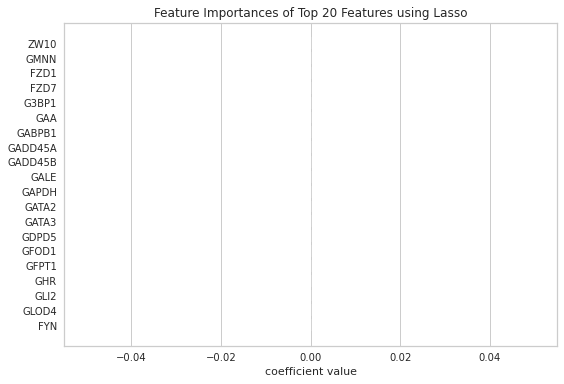

Cells_RadialDistribution_RadialCV_Mito_1of4


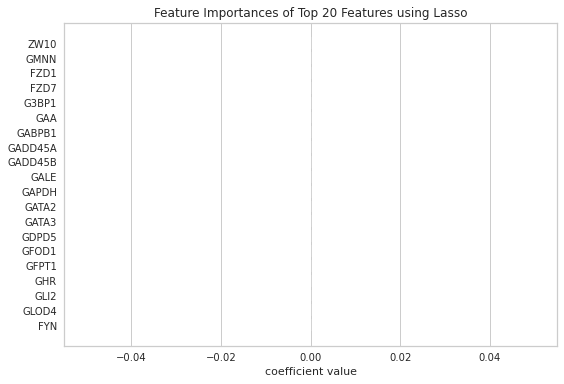

Cytoplasm_Granularity_3_RNA


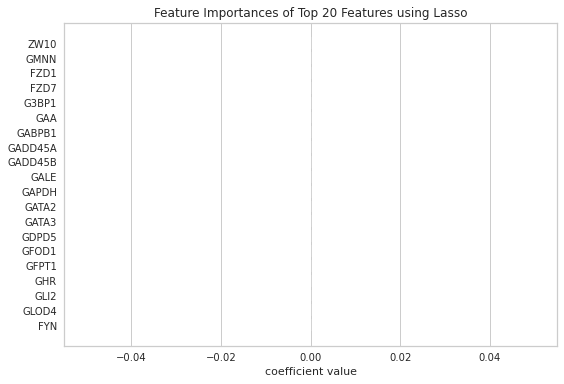

In [56]:
if which_dataset_to_use=="genetic":
    dataset='LUAD';
elif which_dataset_to_use=="chemical":
    dataset='LINCS';    


################################################
pertColName='PERT'

mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features=\
readMergedProfiles(procProf_dir,dataset,'normalized','treatment',1,'highRepOverlap');


l1k=mergProf_treatLevel[[pertColName]+l1k_features]
cp=mergProf_treatLevel[[pertColName]+cp_features]


if dataset=='LINCS':     
    cp['Compounds']=cp['PERT'].str[0:13]
    l1k['Compounds']=l1k['PERT'].str[0:13]
else:
    cp['Compounds']=cp['PERT']
    l1k['Compounds']=l1k['PERT']      


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))


model='Lasso'

if 1:
    cp=cp_scaled.copy()
    l1k=l1k_scaled.copy()

##############################
k_fold=10
pred_df=pd.DataFrame(index=range(k_fold),columns=cp_features_under_test)
pred_df_rand=pd.DataFrame(index=range(k_fold),columns=cp_features_under_test)

meta=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/affy_probe_gene_mapping.txt",delimiter="\t",header=None, names=["probe_id", "gene"])
meta_gene_probID=meta.set_index('probe_id')
d = dict(zip(meta_gene_probID.index, meta_gene_probID['gene']))
l1k_features_gn=[d[l] for l in l1k_features]
l1k = l1k.rename(columns=d)    

for c in cp_test_feats:
    print(c)
#     vv=linear_model_feature_ranking(l1k[l1k_features],cp[c],k_fold,group_labels,l1k_features_gn)
    from sklearn.ensemble import RandomForestClassifier
#     from yellowbrick.datasets import load_occupancy
    from yellowbrick.model_selection import FeatureImportances
    # Load the classification data set
    model = linear_model.LinearRegression()
    model.fit(l1k[l1k_features_gn],cp[c])
#     model = RandomForestClassifier(n_estimators=10)
#     viz = FeatureImportances(model,topn=20)
    viz = FeatureImportances(linear_model.Lasso(),relative=True, topn=20)

    viz.fit(l1k[l1k_features_gn],cp[c])
    viz.show()
    
    
    
#     sfkdna


# filename=results_dir+'/SingleCPfeatPred/scores.xlsx'

# profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])        

# saveAsNewSheetToExistingFile(filename,pd.concat([meltedPredDF,meltedPredDF_rand],ignore_index=True),\
#                              model+'-'+dataset+'-'+profTypeAbbrev+'-'+f+'-'+str(k_fold)+'-ht')


    
#     return 

# with Pool(10) as p:
#     p.map(f, datasets)        

Cytoplasm_AreaShape_Zernike_9_3


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4025574500339738, tolerance: 0.0198
  model = cd_fast.enet_coordinate_descent(


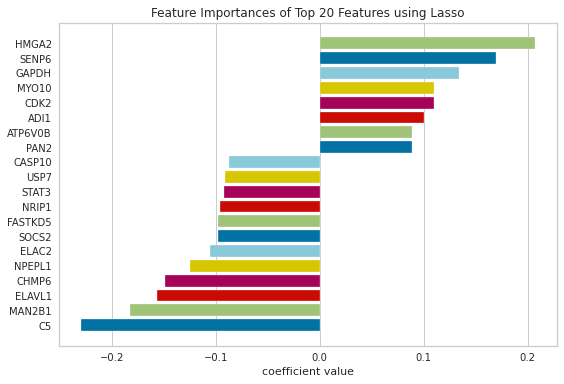

Cells_RadialDistribution_RadialCV_Mito_1of4


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3805892404270581, tolerance: 0.0198
  model = cd_fast.enet_coordinate_descent(


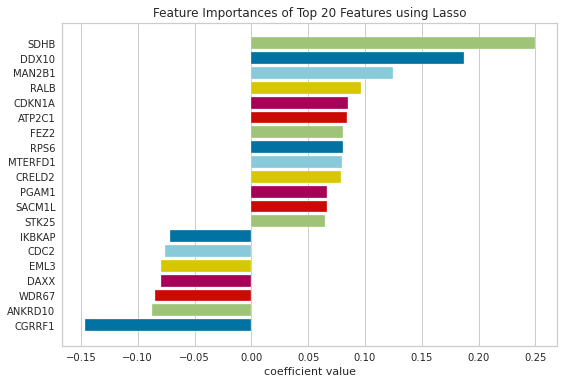

Cytoplasm_Granularity_3_RNA


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44310869502935485, tolerance: 0.0198
  model = cd_fast.enet_coordinate_descent(


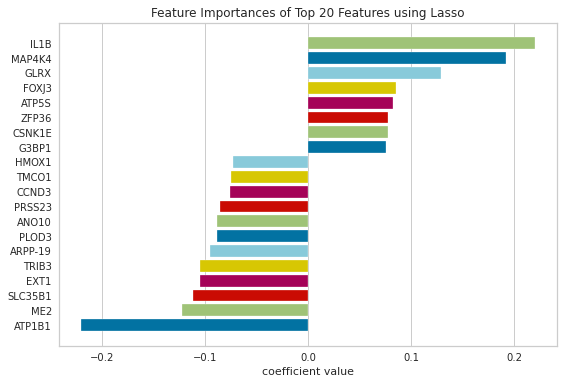

In [65]:
for c in cp_test_feats:
    print(c)
#     vv=linear_model_feature_ranking(l1k[l1k_features],cp[c],k_fold,group_labels,l1k_features_gn)
    from sklearn.ensemble import RandomForestClassifier
#     from yellowbrick.datasets import load_occupancy
    from yellowbrick.model_selection import FeatureImportances
    # Load the classification data set
    model = linear_model.LinearRegression()
    model.fit(l1k[l1k_features_gn],cp[c])
#     model = RandomForestClassifier(n_estimators=10)
#     viz = FeatureImportances(model,topn=20)
    viz = FeatureImportances(linear_model.Lasso(alpha=0.001), labels=l1k_features_gn, relative=False,topn=20)

    viz.fit(l1k[l1k_features_gn],cp[c])
    viz.show()
    

Cytoplasm_AreaShape_Zernike_9_3


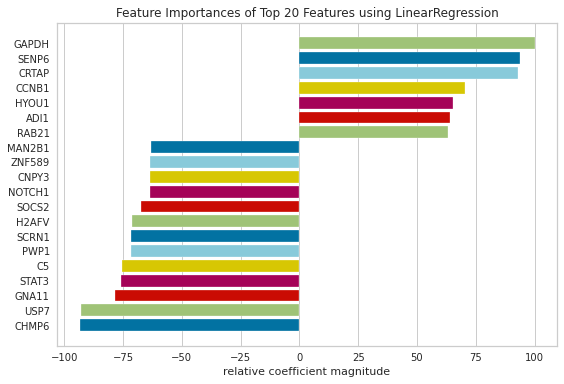

Cells_RadialDistribution_RadialCV_Mito_1of4


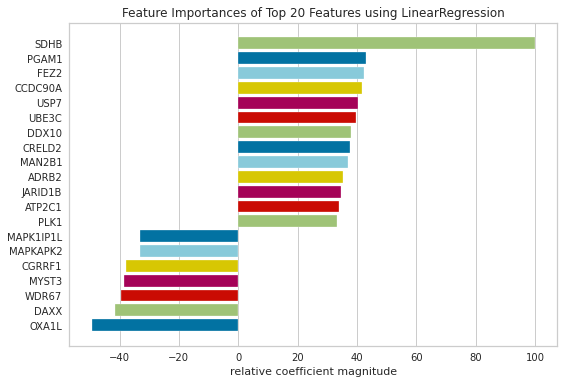

Cytoplasm_Granularity_3_RNA


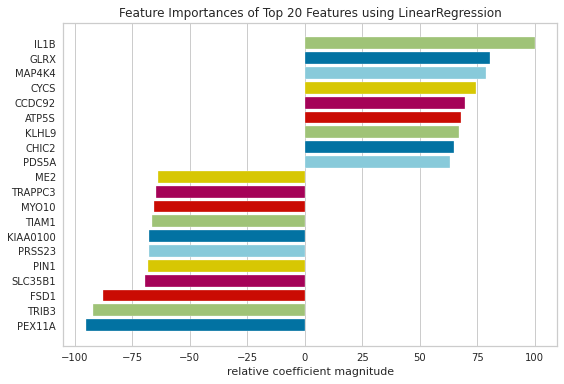

In [52]:
for c in cp_test_feats:
    print(c)
#     vv=linear_model_feature_ranking(l1k[l1k_features],cp[c],k_fold,group_labels,l1k_features_gn)
    from sklearn.ensemble import RandomForestClassifier
#     from yellowbrick.datasets import load_occupancy
    from yellowbrick.model_selection import FeatureImportances
    # Load the classification data set
    model = linear_model.LinearRegression()
    model.fit(l1k[l1k_features_gn],cp[c])
#     model = RandomForestClassifier(n_estimators=10)
    viz = FeatureImportances(model,topn=20)
    viz.fit(l1k[l1k_features_gn],cp[c])
    viz.show()

In [45]:
vv

array([ 2.04549485e-02, -7.58797258e-03, -7.65245729e-04,  2.51112155e-02,
       -2.75239315e-02,  5.74351496e-03,  3.31342225e-02,  1.29870440e-02,
       -1.41858151e-03,  5.27273014e-03,  1.69722116e-02, -1.36293560e-02,
       -8.89495854e-03,  3.97604096e-03, -2.00692265e-03, -1.11933227e-02,
        1.11683725e-02, -2.82688920e-02,  3.42782326e-02,  7.60963438e-04,
       -1.38756711e-02, -3.02794474e-02,  1.23271704e-02,  6.29606745e-03,
       -1.07477992e-03, -3.35177765e-03,  3.57036660e-03,  2.97115049e-02,
        3.87158360e-03,  7.05514328e-03, -1.22376331e-02,  1.81075143e-02,
       -2.36721469e-02, -4.42699142e-03,  4.76125635e-03,  6.61868718e-03,
        2.46233716e-02, -7.14407848e-03,  1.14308704e-02,  1.81832635e-02,
       -1.74531616e-02,  1.98633531e-03,  6.14022010e-03,  8.82097239e-03,
        1.25800985e-02,  8.55867962e-03, -1.25744066e-02,  4.90408702e-03,
       -1.53986968e-02,  1.82150587e-02,  1.31252853e-02,  5.94574280e-03,
        7.28085736e-03, -

In [33]:
# cp_features.index(cp_test_feats[2])
vv1,vv2=linear_model_feature_ranking(l1k[l1k_features],cp[c],k_fold,group_labels,l1k_features_gn)

In [42]:
vv1[258]

-3.379211214103549e-06

In [41]:
np.argsort(abs(vv1)),np.argsort(abs(vv2))

(array([258, 742, 968, 743, 233, 322, 480, 263, 683, 367, 593,  84, 787,
        494, 823, 619, 498, 880, 889, 956, 390, 451, 369, 679, 658, 885,
        709, 763, 580, 421, 355, 924, 522, 717,  63, 307, 201, 128, 604,
        668, 444, 115, 443, 511,  19,   2, 154, 180, 888, 959, 842, 628,
        314, 921, 277, 845,  24, 614, 599, 182,  82, 184, 412, 245, 762,
        574, 508,  61, 349, 603, 253,   8, 844, 484, 186, 865, 877, 736,
        504, 687, 417, 898, 951,  78, 269, 907, 293, 639, 214, 748, 697,
        430, 225, 778, 280, 560, 735, 828, 213, 866, 483, 320, 114, 741,
         41,  14, 822, 799, 450, 922, 899, 554, 647, 120, 240, 487, 377,
        802, 198, 157, 673, 497,  60, 126,  97, 447, 435, 270, 875, 399,
        964, 274, 642, 747, 226, 755, 524,  94, 106, 657, 803, 392, 774,
        781, 707, 952, 537, 364, 140, 916, 698, 190, 102, 458, 847, 401,
        385, 702, 806, 953, 448, 279, 358, 287,  25, 793, 122, 431, 800,
        681, 656, 751, 772,  26, 744, 362, 252, 920

In [20]:
meta=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/affy_probe_gene_mapping.txt",delimiter="\t",header=None, names=["probe_id", "gene"])
meta_gene_probID=meta.set_index('probe_id')
d = dict(zip(meta_gene_probID.index, meta_gene_probID['gene']))
l1k_features_gn=[d[l] for l in l1k_features]

In [21]:
l1k_features_gn

['PSME1',
 'CISD1',
 'LOC100133724///VDAC1',
 'SORBS3',
 'SPDEF',
 'ATF1',
 'SPAG4',
 'E2F2',
 'RHEB',
 'IGF1R',
 'SLC5A6',
 'FOXO3',
 'RGS2',
 'GSTM2',
 'SCYL3',
 'RHOA',
 'TBX2',
 'DNAJA3',
 'IL1B',
 'ASAH1',
 'DCUN1D4',
 'DYRK3',
 'RALA',
 'ARHGEF12',
 'POLG2',
 'SOX2',
 'TRAPPC3',
 'SERPINE1',
 'TCFL5',
 'CRK',
 'HLA-DMA',
 'EGF',
 'RBM34',
 'ITGB1BP1',
 'SPTLC2',
 'ACLY',
 'APP',
 'RAD51C',
 'TSKU',
 'SMC1A',
 'TMEM2',
 'NOS3',
 'YME1L1',
 'ACAA1',
 'CSNK1A1',
 'HSPA8',
 'NFATC4',
 'CCNB1',
 'TBP',
 'SLC2A6',
 'WFS1',
 'EZH2',
 'UBE3B',
 'ICAM3',
 'NPDC1',
 'ALDH7A1',
 'BRCA1',
 'NFATC3',
 'PSMD4',
 'PCNA',
 'PHKG2',
 'ETV1',
 'POLR2I',
 'JARID1B',
 'PSMB8',
 'AKAP8L',
 'COG4',
 'MCM3',
 'PLEKHJ1',
 'HAT1',
 'TERT',
 'G3BP1',
 'SNX13',
 'PAK4',
 'TPD52L2',
 'DPH2',
 'PIH1D1',
 'PRKCQ',
 'SNX6',
 'EED',
 'SHB',
 'UTP14A',
 'WIPF2',
 'NENF',
 'TSEN2',
 'RPN1',
 'SUV39H1',
 'C2CD2L',
 'LYPLA1',
 'BIRC2',
 'GABPB1',
 'MAP2K5',
 'POLR2K',
 'PTK2B',
 'PUF60',
 'DHRS7',
 'PAF1',
 'ARID5B

In [17]:
saveAsNewSheetToExistingFile(filename,pd.concat([meltedPredDF,meltedPredDF_rand],ignore_index=True),\
                             model+'-'+dataset+'-fSel-dists')

[<Worksheet "Lasso-TAORF">, <Worksheet "Lasso-LUAD">, <Worksheet "Lasso-LINCS">, <Worksheet "Lasso-CDRP">, <Worksheet "Lasso-random">, <Worksheet "Lasso-TAORF-all">, <Worksheet "Lasso-LUAD-all">, <Worksheet "Lasso-LINCS-all">, <Worksheet "Lasso-CDRP-all">, <Worksheet "Lasso-random-all">, <Worksheet "Lasso-TAORF-fSel">, <Worksheet "Lasso-LINCS-fSel">, <Worksheet "Lasso-CDRP-bio-fSel">, <Worksheet "Lasso-CDRP-bio-fSel-dists">, <Worksheet "Lasso-LUAD-fSel-dists">, <Worksheet "Lasso-LINCS-fSel-dists">, <Worksheet "Lasso-TAORF-fSel-dists">, <Worksheet "MLP-TAORF-fSel-dists-filt">, <Worksheet "MLP-LUAD-fSel-dists-filt">, <Worksheet "Lasso-CDRP-bio-fSel-dists-2">, <Worksheet "MLP-LINCS-fSel-dists-filt">, <Worksheet "Lasso-LUAD-fSel-dists-filt">, <Worksheet "Lasso-TAORF-fSel-dists-filt">, <Worksheet "Lasso-LINCS-fSel-dists-filt">, <Worksheet "MLP-TAORF-fSel-dists">, <Worksheet "MLP-LUAD-fSel-dists">, <Worksheet "MLP-CDRP-bio-fSel-dists-2">]


### Single Gene prediction cross validation

### Single CP feature prediction cross validation

In [26]:
dataset

'LINCS'

### CP Category specific scores for single gene prediction

In [72]:
# relationMat_mpCat.isnull(axis=1)
# Channelss=['DNA','RNA','AGP','Mito','ER']
# featureGroups=['Texture','Intensity','RadialDistribution']
# cp.columns[cp.columns.str.contains(Channelss[0]) &\
#                cp.columns.str.contains(featureGroups[2]) &\
#                cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()

In [74]:
relationMat_mpCat.columns[~relationMat_mpCat.isna().any()].tolist()

['DNA_Texture',
 'DNA_Intensity',
 'RNA_Texture',
 'RNA_Intensity',
 'RNA_RadialDistribution',
 'AGP_Texture',
 'AGP_Intensity',
 'AGP_RadialDistribution',
 'Mito_Texture',
 'Mito_Intensity',
 'Mito_RadialDistribution',
 'ER_Texture',
 'ER_Intensity',
 'ER_RadialDistribution',
 'Nuclei_AreaShape',
 'Cytoplasm_AreaShape',
 'Cells_AreaShape']

In [110]:
k_fold=10
Channelss=['DNA','RNA','AGP','Mito','ER']
featureGroups=['Texture','Intensity','RadialDistribution']
relationMat_mpCat=pd.DataFrame(index=l1k_features)
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):    
        selectedCols=cp.columns[cp.columns.str.contains(Channelss[ch]) &\
                       cp.columns.str.contains(featureGroups[f]) &\
                       cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist();
        for l in l1k_features:
            scores,scores_rand=lasso_cv(cp[selectedCols],l1k[l],k_fold)
        
            relationMat_mpCat.loc[l,Channelss[ch]+'_'+featureGroups[f]]=np.median(scores)

Channelss=['Nuclei','Cytoplasm','Cells']
featureGroups=['AreaShape']

for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):    
        selectedCols=cp.columns[cp.columns.str.contains(Channelss[ch]) &\
                       cp.columns.str.contains(featureGroups[f]) &\
                       cp.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist();
        for l in l1k_features:
            scores,scores_rand=lasso_cv(cp[selectedCols],l1k[l],k_fold)
        
            relationMat_mpCat.loc[l,Channelss[ch]+'_'+featureGroups[f]]=np.median(scores)
            
########################### mapping prob_ids to genes names    
meta=pd.read_csv("/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/affy_probe_gene_mapping.txt",delimiter="\t",header=None, names=["probe_id", "gene"])
meta_gene_probID=meta.set_index('probe_id')
d = dict(zip(meta_gene_probID.index, meta_gene_probID['gene']))
relationMat_mpCat = relationMat_mpCat.rename(index=d)    


In [111]:
relationMat_mpCat=relationMat_mpCat[relationMat_mpCat.columns[~relationMat_mpCat.isna().any()].tolist()]
topGenes_df=relationMat_mpCat[relationMat_mpCat.max(axis=1)>0.1]#.head()
topGenes_df2=relationMat_mpCat[relationMat_mpCat.max(axis=1)>0.5]#.head()
topGenes_df2.shape

(91, 18)

In [196]:
topGenes_mito_radial=relationMat_mpCat[relationMat_mpCat["Mito_RadialDistribution"].abs()>0.6]

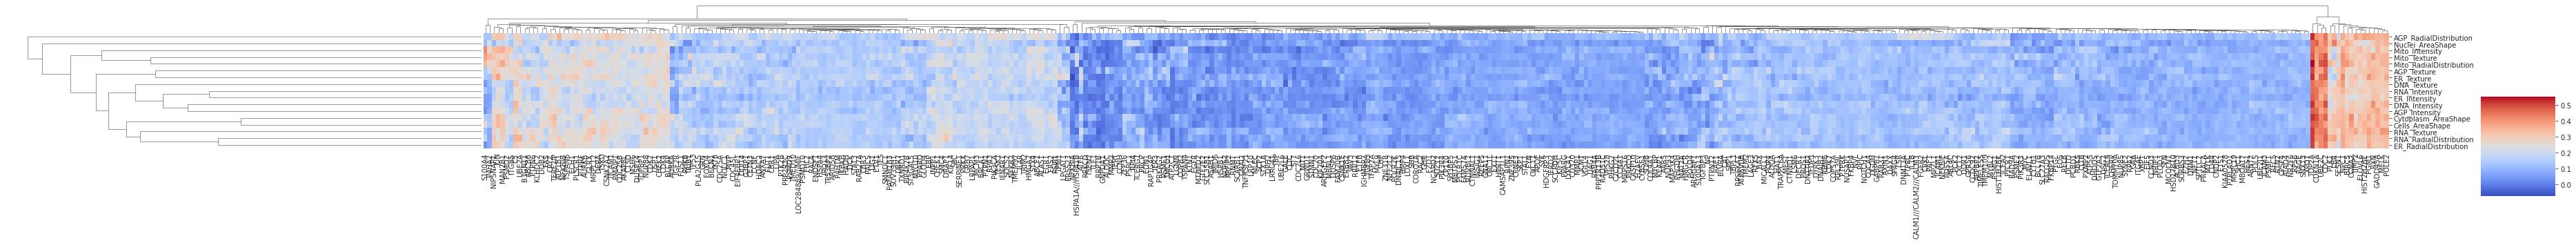

In [87]:
# plt.figure()
# f, axes = plt.subplots(figsize=(15,4))
# ax = sns.heatmap(topGenes_df)
clustergrid=sns.clustermap(topGenes_df.T,xticklabels=1,yticklabels=1,figsize=(50, 5),cmap="coolwarm",cbar_pos=(1, 0.2, .03, .4))


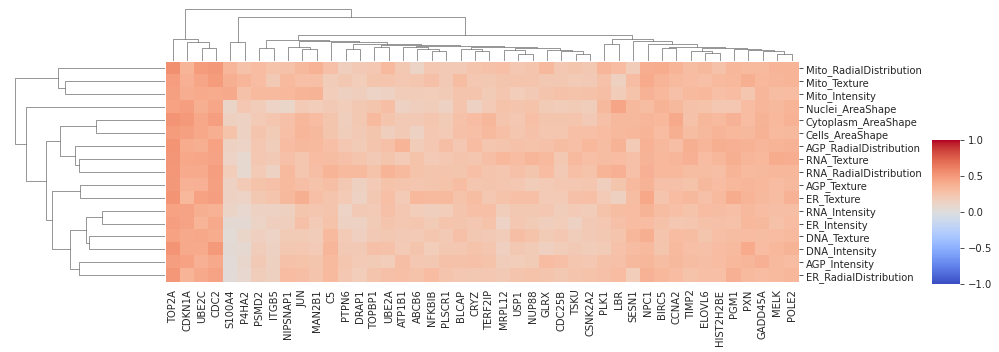

In [79]:
# clustergrid=sns.clustermap(topGenes_df2.T,xticklabels=1,yticklabels=1,figsize=(10, 5),cmap="vlag",\
#                            vmin=-1, vmax=1,cbar_pos=(1, 0.2, .03, .4))
%matplotlib inline
clustergrid=sns.clustermap(topGenes_df2.T,xticklabels=1,yticklabels=1,figsize=(13, 5),cmap="vlag",\
                           vmin=-1, vmax=1,cbar_pos=(1, 0.2, .03, .4))
clustergrid.savefig('../../results/cpCategoriesHM-'+dataset+'.png', format='png',dpi=100)

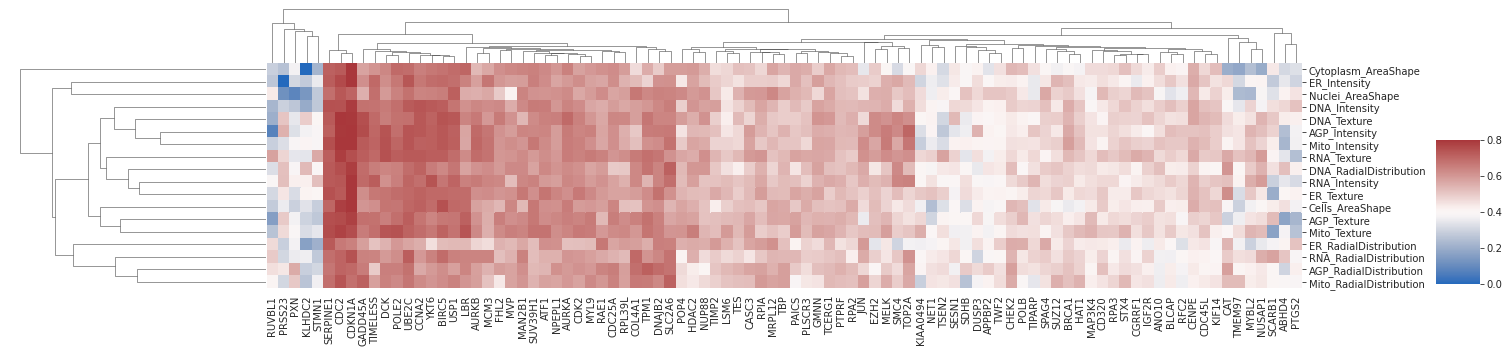

In [116]:
%matplotlib inline
clustergrid=sns.clustermap(topGenes_df2.T,xticklabels=1,yticklabels=1,figsize=(20, 5),cmap="vlag",\
                           vmin=0, vmax=0.8,cbar_pos=(1, 0.2, .03, .4))
# clustergrid.savefig('../../results/cpCategoriesHM-'+dataset+'.png', format='png',dpi=100)

In [ ]:
# Replicate correlations in different channels
Channelss=['DNA','Protein','Mito','ER']
featureGroups=['Texture','Intensity','RadialDistribution']
# Channelss=['DNA']
# featureGroups=['Texture','Intensity']
fig, axes = plt.subplots(4,3,sharey='row', figsize=(8,10))
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):    
        colss=df_meanPrepCorr.columns[df_meanPrepCorr.columns.str.contains(Channelss[ch]) &\
                                   df_meanPrepCorr.columns.str.contains(featureGroups[f]) &\
                          df_meanPrepCorr.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist();
#         print(colss)
        repCC,randCC=utils.meanProfileAnalysis.categoricalRepCor(df_meanPrepCorr,'Metadata_Sample',colss,0);
#         sns.kdeplot(repCC, bw=.1,ax=axes[ch,f]);
#         sns.kdeplot(randCC, bw=.1,ax=axes[ch,f]);
        sns.distplot(randCC,kde=True,hist=True,bins=12,label="random pairs",ax=axes[ch,f],norm_hist=True);
    #         sns.kdeplot(randCC, bw=.2, label="random pairs",ax=axes[i])
        sns.distplot(repCC,kde=True,hist=True,bins=12,label="replicate pairs",ax=axes[ch,f],norm_hist=True);        
        
        
#         perc5=np.percentile(repCC, 15);axes[i,j].axvline(x=0,linestyle=':');        
        axes[ch,f].set_title(featureGroups[f]);
#         axes[i,j].get_yaxis().set_visible(False)
#         axes[i,j].get_xaxis().set_visible(False)
        axes[ch,0].set_ylabel(Channelss[ch]);



In [ ]:
Channelss=['Nuclei','Cytoplasm','Cells']
featureGroups=['AreaShape']
# Channelss=['DNA']
# featureGroups=['Texture','Intensity']
fig, axes = plt.subplots(1,3,sharey='row', figsize=(8,3))
for ch in range(len(Channelss)):
    for f in range(len(featureGroups)):    
        colss=df_meanPrepCorr.columns[df_meanPrepCorr.columns.str.contains(Channelss[ch]) &\
                                   df_meanPrepCorr.columns.str.contains(featureGroups[f]) &\
                          df_meanPrepCorr.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist();
#         print(colss)
        repCC,randCC=utils.meanProfileAnalysis.categoricalRepCor(df_meanPrepCorr,'Metadata_Sample',colss,0);

        sns.distplot(randCC,kde=True,hist=True,bins=12,label="random pairs",ax=axes[ch],norm_hist=True);
    #         sns.kdeplot(randCC, bw=.2, label="random pairs",ax=axes[i])
        sns.distplot(repCC,kde=True,hist=True,bins=12,label="replicate pairs",ax=axes[ch],norm_hist=True);                
        
#         perc5=np.percentile(repCC, 15);axes[i,j].axvline(x=0,linestyle=':');        
        axes[ch].set_title(Channelss[ch]);

        axes[0].set_ylabel(featureGroups[f]);


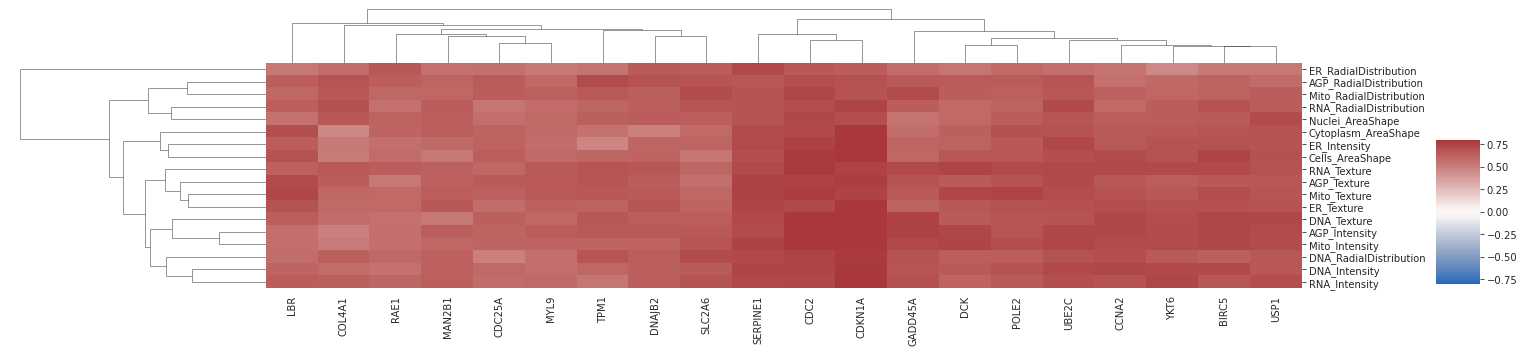

In [212]:
topGenes_mito_radial=relationMat_mpCat[relationMat_mpCat["Mito_RadialDistribution"]>0.6]#[["Mito_RadialDistribution"]]
clustergrid=sns.clustermap(topGenes_mito_radial.T,xticklabels=1,yticklabels=1,figsize=(20, 5),cmap="vlag",\
                           vmin=-0.8, vmax=0.8,cbar_pos=(1, 0.2, .03, .4))

In [215]:
topGenes_mito_radial.sort_values(by='Mito_RadialDistribution').index.values

array(['RAE1', 'MAN2B1', 'YKT6', 'LBR', 'BIRC5', 'CCNA2', 'POLE2', 'MYL9',
       'DNAJB2', 'USP1', 'CDC25A', 'DCK', 'TPM1', 'COL4A1', 'UBE2C',
       'CDKN1A', 'SERPINE1', 'SLC2A6', 'GADD45A', 'CDC2'], dtype=object)